In [131]:
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from symmetries.training_utils import CnLoader

In [132]:
# define network

class SymNet(torch.nn.Module):
    
    def __init__(self, n):
        super(SymNet, self).__init__()
        self.n = n
        self.A = Parameter(torch.Tensor(n,n))
        self.htheta = torch.nn.Sequential(torch.nn.Linear(1,128), torch.nn.ReLU(),
                                         torch.nn.Linear(128,128), torch.nn.ReLU(),
                                         torch.nn.Linear(128, 1))
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init._no_grad_normal_(self.A, 0, 1)
        
    def forward(self, f):
        A = F.softmax(self.A, dim = 0)
        f = f.t()
        Af = A@f
        Af = Af.t()
        Af = Af.flatten().reshape(-1,1)
        
        hAf = self.htheta(Af)
        batch_size = int(len(f.flatten()) / self.n)
        hAf = hAf.reshape((batch_size, self.n))
        
        return A, hAf
    
    def loss(self, hAf, A, h):
        h = h.t()
        Ah = A@h
        Ah = Ah.t()
        mse = F.mse_loss(hAf, Ah, reduction = 'none').sum(1).mean()
        #A_reg = A.pow(2).sum()
        #total_loss = A_reg + mse
        total_loss = mse
        return total_loss
    
    def show_A(self):
        Anp = F.softmax(self.A.detach(), dim = 0).numpy()
        plt.matshow(Anp)
        plt.show()
        plt.close()
        return Anp
        

In [133]:
# load data
data_dir = '/home/chris/projects/symmetries/data'
out_name = '/c6_signals.npz'
data = np.load(data_dir + out_name)
Fu,H = data['F'], data['H']

In [134]:
# build model
mod = SymNet(6).double()
opt = torch.optim.Adam(mod.parameters(), lr = 1e-2)

In [135]:
# train
tr_cutoff = 5000
epochs = 1000
batch_size = 32
num_examples = 1028
ep_losses = []
ep_loss = 0

H_tr, Fu_tr, H_tst, Fu_tst = H[0:tr_cutoff, :], Fu[0:tr_cutoff, :], H[tr_cutoff:, :], Fu[tr_cutoff:, :]
tr_loader, tst_loader = CnLoader(H_tr, Fu_tr, num_examples), CnLoader(H_tst, Fu_tst, num_examples)

for ep in range(epochs):
    H_tr, Fu_tr = tr_loader.next(batch_size)
    A, hAf = mod(Fu_tr)
    loss = mod.loss(hAf, A, H_tr)
    ep_loss += loss.item()
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if (ep + 1) % (int(num_examples/batch_size)) == 0:
        ep_losses.append(ep_loss)
        ep_loss = 0

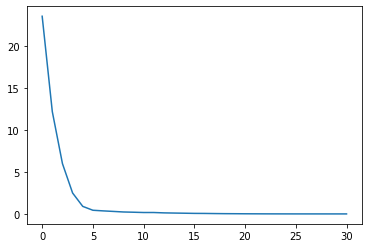

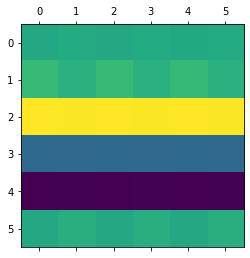

In [136]:
plt.plot(ep_losses)
plt.show()
plt.close()

Anp = mod.show_A()